In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import CBcm

In [2]:
from scipy import stats

import iminuit

In [3]:
sys.path.append('/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules')

In [4]:
common_settings = pickle.load(open('/home/jp/projects/atm_nu/ddm_results/final_settings/common_settings_daemon.pkl'))

In [5]:
import mufit
reload(mufit)
import mufit_plots as mfp
reload(mfp)

MUFIT: Using quickflux2!
MUFIT: Using quickflux2!
MufitPlots does not use the mceq flux evaluator directly
MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

In [7]:
fitname = 'daemon_prd_nd_test'
filename = '/home/jp/projects/atm_nu/ddm_results/'+fitname+'.pkl'

old_fitname = 'daemon_prd_nodeis2'
old_filename = '/home/jp/projects/atm_nu/ddm_results/'+old_fitname+'.pkl'

savefig = True

In [8]:
fit = mufit.MuFit(datasets = ['bessfull',
                              'l3c', 
                              'opera', 
                              'minos',
                              'cms',
                              #'deis',
                              'mutronratio',
                             'deisratio'
                             ],

                 flux_splines = 'daemon-v4',)


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230323_2.pkl
Entering version with 5 entries
Excluded params removed from known_params.
No calibration file for daemon-v4
('Did not find an average flux', KeyError('average',))
Adjusting DEIS name
daemon-v4
('Using errors in mode: ', 'mixed')
MUTRON ratio: adding ALL errors in quadrature
DEIS ratio: adding ALL errors in quadrature


In [11]:
fit.explist['l3c'].model_flux

{}

In [12]:
physics_params = common_settings['physics_params']

In [13]:
my_flux_parameters = {}
for onep in physics_params:
    if 'GSF' in onep:
        my_flux_parameters[onep] = [0., False, -4, 4, 0., 1]
    elif ('31G' in onep) or ('158G' in onep):
        my_flux_parameters[onep] = [0., False, -10, 10, 0., 1]
    elif ('20T' in onep) or ('2P' in onep):
        if 'pi+' in onep:
            my_flux_parameters[onep] = [-0.3, False, -5., 5.,  0.,  1.8]
        elif 'pi-' in onep:
            my_flux_parameters[onep] = [0,False, -33,  33,    0,  10]
        elif 'K+' in onep:
            my_flux_parameters[onep]= [ 0., False, -19,  19,  0,  10]
        elif 'K-' in onep:
            my_flux_parameters[onep]=[-14., False, -40,  30, 10.,  20.]
        elif 'p' in onep:
            my_flux_parameters[onep]=[12., False, -16, 16,  0., 6]
        elif 'n' in onep:
            my_flux_parameters[onep]=[0., False, -6, 6,   0,  2.5]
#for onep in physics_params:
#    print(onep, my_flux_parameters[onep])
    
mysyst = deepcopy(fit.systematics)
mysyst.update({# Fixing DEIS because errors are included by default
               'deis_mscat':  [0.0, True, -3, 3],
               'deis_bfield':  [0.0, True, -3, 3],
               'deis_norm':  [0.0, True, -3, 3],

               # L3c (all)
               'l3c_align': 0.0042, #np.random.uniform(-3,3),
               'l3c_bfield': -3.30, #np.random.uniform(-3,3),
               'l3c_eloss': -2.92, #np.random.uniform(-3,3),
               'l3c_overb': -0.5, #np.random.uniform(-3,3),
               'l3c_normHor': -1.41, #np.random.uniform(-3,3),
               'l3c_normVert': -1.591, #np.random.uniform(-3,3),
               'l3c_pres': 1.352, #np.random.uniform(-3,3),

               'mn_escale': -1.59, #np.random.uniform(-3,3),

               # Bess
               'bess_align': -1.72, #np.random.uniform(-3,3),
               'bess_finres': 0.2, #np.random.uniform(-3,3),
               })

In [14]:
# Check if there's a previous fit, start from there
if os.path.isfile(old_filename):
    old_result = pickle.load(open(old_filename,'rb'))
    print('Updating starting values')
    for onekey in my_flux_parameters:
        my_flux_parameters[onekey][0] = old_result['params'][onekey]['value']
    for onekey in mysyst:
        if type(mysyst[onekey]) == list:
            mysyst[onekey][0] = old_result['params'][onekey]['value']    
        else:
            mysyst[onekey] = old_result['params'][onekey]['value'] 


Updating starting values


In [15]:
nfits = 1
counter = 0
bestfit = 1E9
defprior = 60
for ifit in range(nfits):
    print 'Internal fit ', ifit
    
    # Start at best fit from previous fit
    if bestfit<1E9:
        for onekey in my_flux_parameters:
            my_flux_parameters[onekey][0] = fit.results['params'][onekey]['value']
        for onekey in mysyst:
            if type(mysyst[onekey]) == list:
                mysyst[onekey][0] = fit.results['params'][onekey]['value']    
            else:
                mysyst[onekey] = fit.results['params'][onekey]['value']  
            
    # Change some parameters slightly
    for i in range(4):
        randkey = my_flux_parameters.keys()[np.random.randint(len(my_flux_parameters))]
        my_flux_parameters[randkey][0] += np.random.normal()
    
    #print(my_flux_parameters)
    
    one_m, one_f = fit.run_fit(
        flux_parameters = my_flux_parameters,        
        exp_parameters = mysyst,
        fit_data = 'all',
        fit_mode = 'physics',
        use_priors = True,
        print_mode = False,
        dry_run = False,
        emin=5.,
        emax=1E9,
        fake_data = False,
        )
    
    this_fit = fit.results['fmin']['fval']
    print 'This fit', this_fit
    if this_fit < bestfit:
        print 'Updated results for fit', this_fit, bestfit
        bestfit = deepcopy(this_fit)
        results = deepcopy(fit.results)
        m = one_m
        f = one_f

Internal fit  0


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit.py:315: RuntimeWarning: invalid value encountered in divide
  phys_priors_mean)**2/phys_priors_err**2)[prior_bool]


Successful fit!
This fit 244.094996906
Updated results for fit 244.094996906 1000000000.0


In [20]:
fit.explist['l3c'].model_flux

{'16.9617': array([0.25188733, 0.2577966 , 0.26217646, 0.26341004, 0.25615283,
        0.23809543, 0.21048467, 0.16939221, 0.11218891]),
 '23.2197': array([0.25320852, 0.25983127, 0.26499286, 0.26711173, 0.26086381,
        0.24355558, 0.21618987, 0.17472989, 0.11659939]),
 '30.4015': array([0.25497034, 0.26275164, 0.2691934 , 0.27280449, 0.26828554,
        0.25229529, 0.22540915, 0.18338228, 0.12338652]),
 '38.0475': array([0.25670849, 0.26620463, 0.2745541 , 0.28046209, 0.27867316,
        0.26492527, 0.23899333, 0.19621894, 0.13283755]),
 '44.5613': array([0.25752943, 0.26897212, 0.27952446, 0.28815433, 0.28970926,
        0.27889023, 0.25448829, 0.21126648, 0.14422839]),
 '50.3943': array([0.2570014 , 0.27064449, 0.28372043, 0.29556788, 0.30122881,
        0.29420579, 0.27198978, 0.22874068, 0.15802679]),
 '55.7711': array([0.25453544, 0.27067388, 0.28665638, 0.30234312, 0.31308979,
        0.31101327, 0.29205302, 0.24939566, 0.17484793]),
 '9.0687': array([0.25071261, 0.25606562,

In [17]:
free_params = 0
for one_param in fit.fit_keys:
    if not fit.minuit_settings['fix_'+one_param]:
        free_params += 1
#print(free_params, len(fit.fit_keys))

In [18]:
all_keys = results['params'].keys()
dof = fit.results['bins']-free_params
print 'Chi2',fit.results['chi2'], '/', dof, 'dof (approximate)'
p_value = 1-stats.chi2.cdf(fit.results['chi2'], dof)
print('P-value', p_value)
syst_keys = []
print '\t'.join(['Param', 'value','error'])
for one_param in physics_params:
    all_keys.remove(one_param)
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])
all_keys.sort()
for one_param in all_keys:
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])



Chi2 198.58336622786834 / 217 dof (approximate)
('P-value', 0.810058381130142)
Param	value	error
pi+_31G	-1.51	0.79
pi-_31G	-2.34	0.41
K+_31G	-1.08	0.77
K-_31G	-0.21	0.99
pi+_158G	-0.12	0.11
pi-_158G	2.73	0.73
K+_158G	0.48	0.98
K-_158G	0.01	0.99
p_158G	-0.12	0.96
n_158G	1.04	0.81
pi+_20T	0.00	0.41
pi-_20T	4.52	2.57
pi+_2P	-2.63	1.62
pi-_2P	9.60	7.81
K+_2P	6.62	6.86
K-_2P	-22.89	14.11
p_2P	5.22	5.68
n_2P	2.21	2.33
GSF_1	1.08	0.92
GSF_2	0.12	0.99
GSF_3	0.04	0.99
GSF_4	0.19	0.99
GSF_5	-0.79	0.98
GSF_6	0.27	0.99
bess_align	-0.36	0.75
bess_finres	0.52	0.82
deis_bfield	0.00	0.50
deis_mscat	0.00	0.50
deis_norm	0.00	0.50
l3c_align	0.06	0.11
l3c_bfield	0.14	0.96
l3c_eloss	0.36	0.93
l3c_normHor	-1.03	0.49
l3c_normVert	-0.93	0.47
l3c_overb	-1.66	0.75
l3c_pres	3.03	0.45
mn_escale	-1.70	0.30


In [14]:
these_errors = np.sqrt(np.diag(m.np_covariance()))

In [15]:
these_errors

array([ 6.69036218,  5.82936867,  0.73488168,  1.65979253, 14.07485129,
        0.9924311 ,  0.80605868,  0.78995196,  0.98201073,  0.99455497,
        2.53895571,  0.10546962,  0.95696842,  0.99948161,  0.99126552,
        0.99745914,  0.9266162 ,  0.99951337,  0.99980205,  0.77273245,
        0.4077722 ,  0.40549717,  7.86762962,  2.40455897,  0.        ,
        0.        ,  0.96217027,  0.75475023,  0.30171594,  0.74892873,
        0.47275282,  0.        ,  0.49494278,  0.82380638,  0.93604642,
        0.44692441,  0.10702411])

In [16]:
fit.results['flux_parameters'] = my_flux_parameters

In [17]:
pickle.dump(fit.results, open(filename, 'wb'))
print('Written', filename)

('Written', '/home/jp/projects/atm_nu/ddm_results/daemon_prd_nd.pkl')


In [18]:
m.matrix(correlation=True)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|              |        K+_2P         p_2P     pi-_158G       pi+_2P        K-_2P       K-_31G       n_158G      pi+_31G      K+_158G      K-_158G      pi-_20T     pi+_158G       p_158G        GSF_4        GSF_5        GSF_6        GSF_1        GSF_2        GSF_3       K+_31G      pi+_20T      pi-_31G       pi-_2P         n_2P   l3c_bfield    l3c_overb    mn_escale   bess_align l3c_normVert  l3c_normHor  bess_finres    l3c_eloss     l3c_pres    l3c_align |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        K+_2P |        1.000       -0.030        0.040       -0.043        0.883        0.001       -0.018        0.004       -0.088        0.035       -0.282        0.121        0.006       -0.001        0.015       -0.017       -0.048       -0.002       -0.001       -0.009       -0.363        0.025        0.064       -0.063       -0.026       -0.031        0.020       -0.009        0.000       -0.036        0.009       -0.000        0.331       -0.018 |
|         p_2P |       -0.030        1.000       -0.144        0.018        0.012        0.003       -0.114        0.001       -0.014       -0.004       -0.266       -0.172       -0.030       -0.001        0.005        0.000       -0.079       -0.001       -0.001        0.003       -0.248        0.026       -0.037       -0.052        0.009        0.040       -0.009        0.031        0.006        0.018       -0.010       -0.000       -0.026        0.015 |
|     pi-_158G |        0.040       -0.144        1.000       -0.004        0.027        0.019       -0.422        0.071        0.032       -0.066        0.152        0.710       -0.129       -0.006        0.018        0.010       -0.269       -0.004       -0.002        0.090        0.109        0.149        0.051       -0.065        0.084        0.114        0.016        0.060       -0.022       -0.049       -0.046        0.067       -0.201       -0.065 |
|       pi+_2P |       -0.043        0.018       -0.004        1.000        0.050       -0.001        0.010       -0.006        0.040       -0.017       -0.112       -0.033       -0.003        0.000       -0.009        0.006        0.015       -0.000        0.000       -0.006       -0.057       -0.023        0.310        0.042        0.006        0.002       -0.086       -0.007       -0.018       -0.013        0.002        0.004        0.162       -0.003 |
|        K-_2P |        0.883        0.012        0.027        0.050        1.000       -0.001        0.047       -0.016        0.084       -0.037       -0.441       -0.049       -0.001        0.010       -0.050        0.022       -0.029        0.009        0.003       -0.004       -0.360       -0.060       -0.177        0.046       -0.017       -0.028       -0.007       -0.016       -0.009       -0.043        0.009        0.006        0.309       -0.000 |
|       K-_31G |        0.001        0.003        0.019       -0.001       -0.001        1.000       -0.031        0.015        0.000        0.001        0.000        0.007       -0.009        0.000       -0.001       -0.000        0.006        0.000        0.000        0.014       -0.002       -0.269        0.

In [19]:
fit.results['cov_params'] = m.list_of_vary_param()
ordered_matrix = np.zeros_like(fit.results['corr_matrix'])
# Need to reorder this business
syst_params = ['l3c_bfield','l3c_overb','l3c_normVert', 'bess_align','bess_finres',
               'l3c_normHor','l3c_eloss','l3c_pres','l3c_align', 'mn_escale']
syst_params.sort()
ordered_phys = np.zeros(len(physics_params))
ordered_syst = np.zeros(len(syst_params))
for ip, one_param in enumerate(physics_params):
    ordered_phys[ip] = fit.results['cov_params'].index(one_param)
for ip, one_param in enumerate(syst_params):
    ordered_syst[ip] = fit.results['cov_params'].index(one_param)
    
full_list = physics_params + syst_params
full_in = np.array(np.concatenate((ordered_phys, ordered_syst)),dtype=int)
for j, one_param in enumerate(full_list):
    for k in range(len(full_in)):
        ordered_matrix[j,k] = fit.results['corr_matrix'][full_in[j], full_in[k]]

In [20]:
if not os.path.exists('/home/jp/projects/atm_nu/ddm_results/'+fitname):
    os.mkdir('/home/jp/projects/atm_nu/ddm_results/'+fitname)

Saving figures


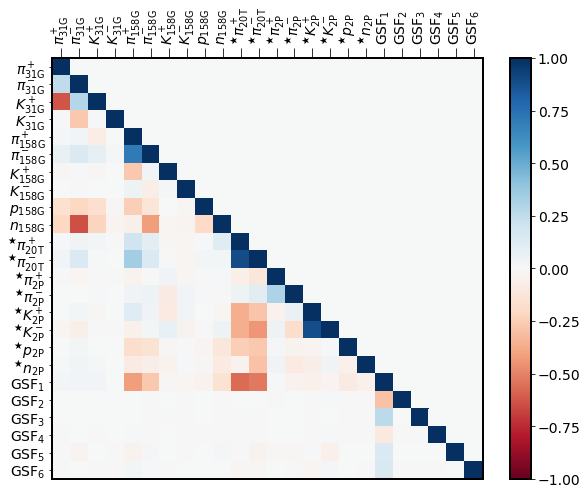

In [21]:
maxb = len(physics_params)
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    params[i] = common_settings['param_legend'][onep]

    
fig = plt.figure(figsize=(12*0.7,10*0.7))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
plt.tight_layout()


if savefig:
    print('Saving figures')
    fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_'+fitname+'.png', dpi=300)
    fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_'+fitname+'.pdf')


Saving figures


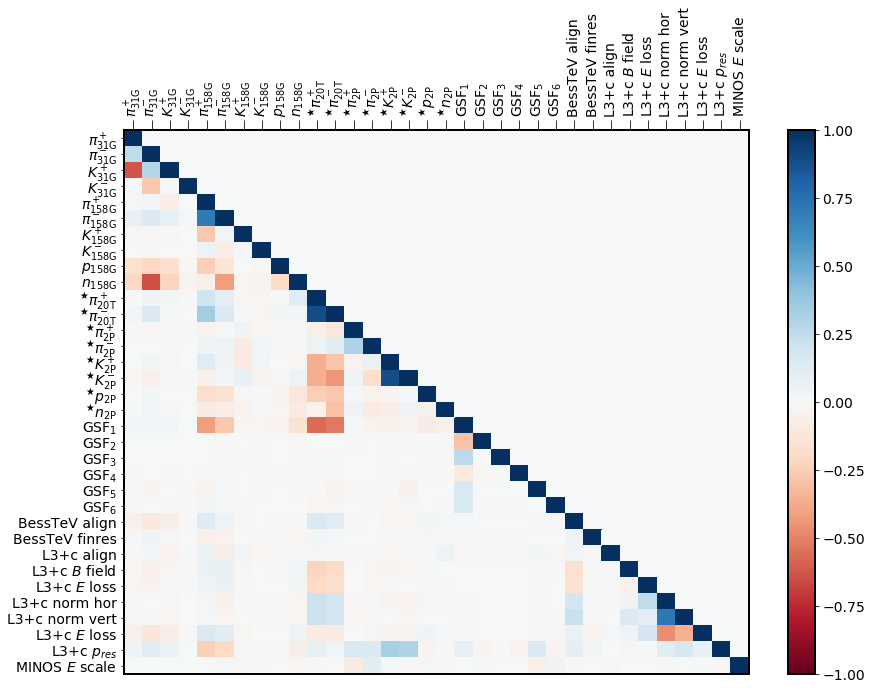

In [22]:
maxb = None
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    params[i] = common_settings['param_legend'][onep]
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()

if savefig:
    print('Saving figures')
    fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_full_'+fitname+'.png', dpi=300)
    fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_full_'+fitname+'.pdf')


Saving figures


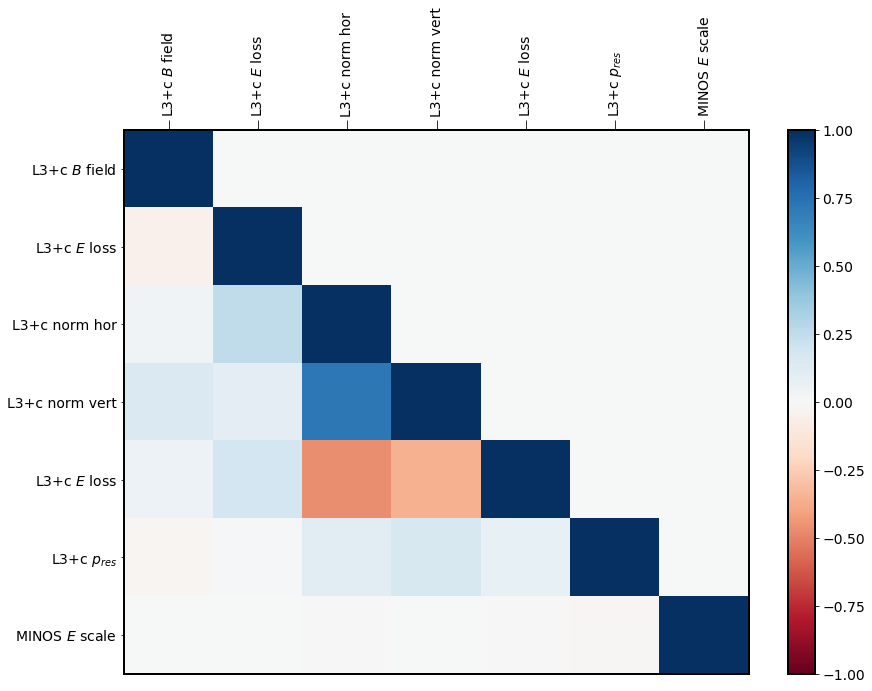

In [23]:
inb = 27
maxb = None
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix[inb:maxb,inb:maxb].shape[0], 1.)
plt.pcolor(corr_matrix[inb:maxb,inb:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[inb:maxb], rotation=90)
plt.yticks(xmarks, params[inb:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
if savefig:
    print('Saving figures')
    fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_syst_'+fitname+'.png', dpi=300)
    fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_syst_'+fitname+'.pdf')


MufitPlots does not use the mceq flux evaluator directly
Flux l3c 38.0475 [9.22512311e-01 2.24299153e-02 5.75143430e-03 1.90748943e-01
 3.76878540e-03 1.15342957e-01 1.85032218e-01 3.19957495e-01
 1.39227096e+01]
Pull sum 74.4764396630975 124.1094996354429


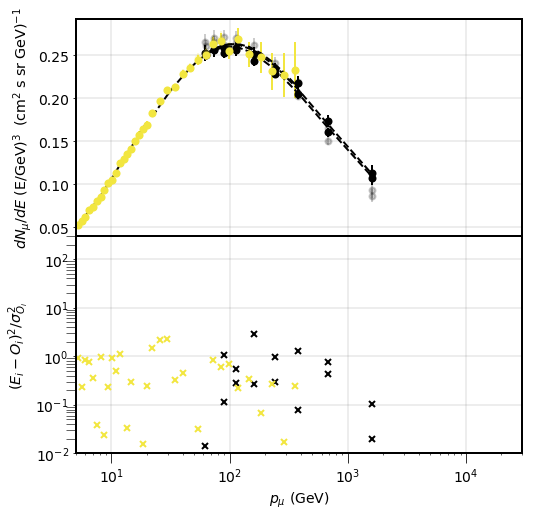

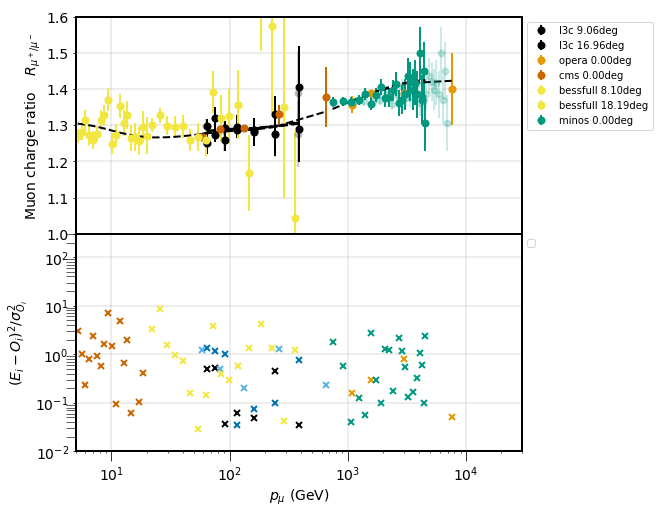

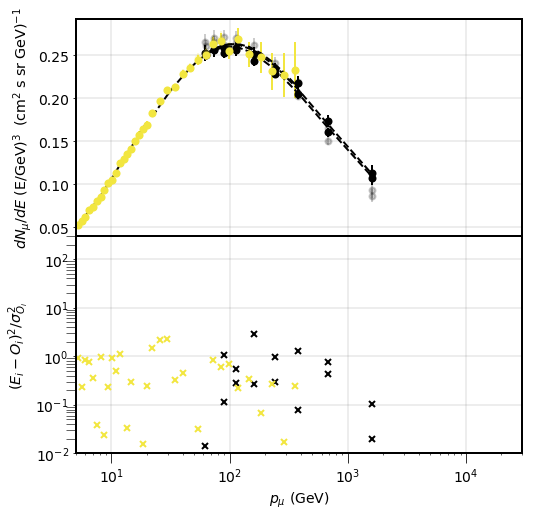

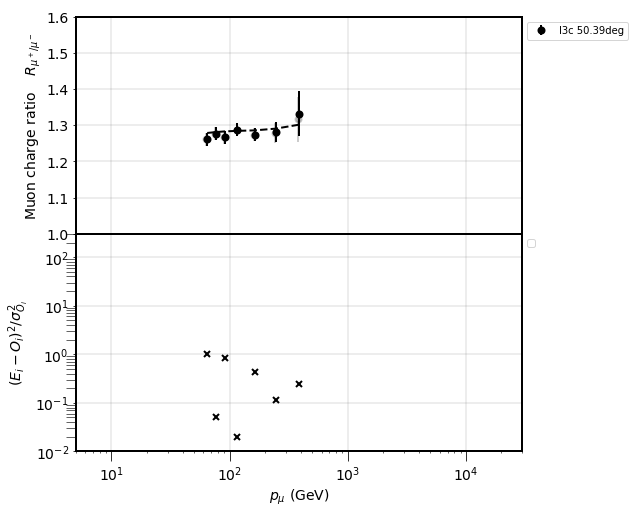

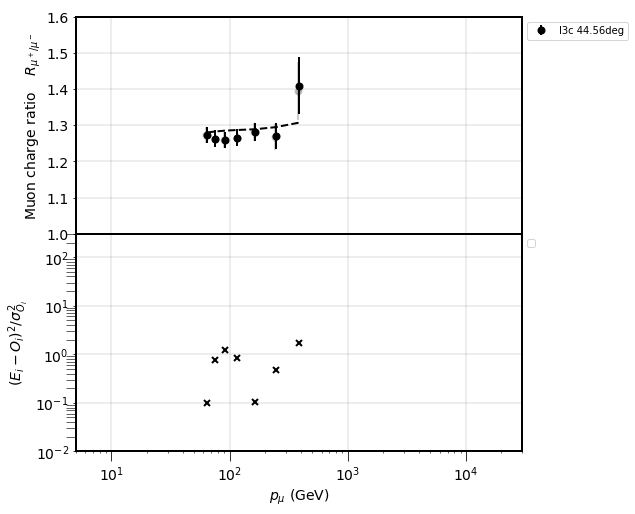

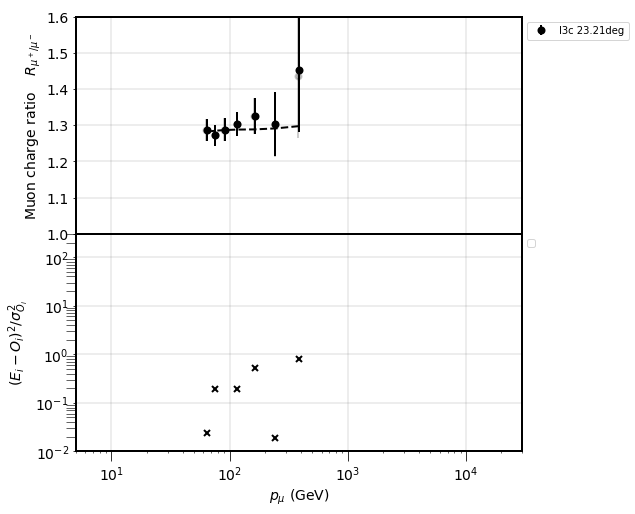

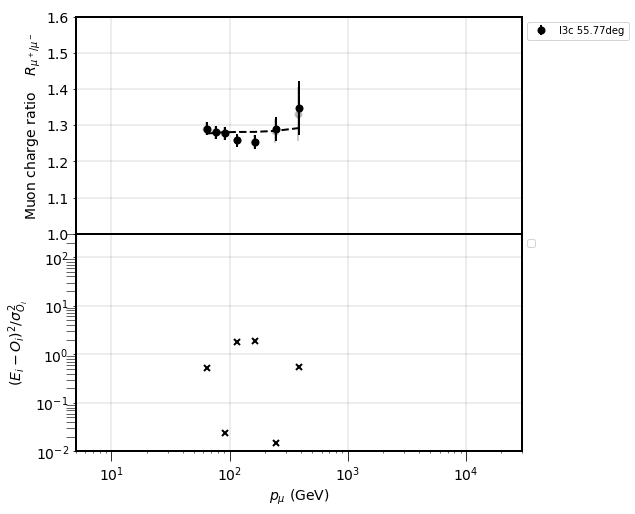

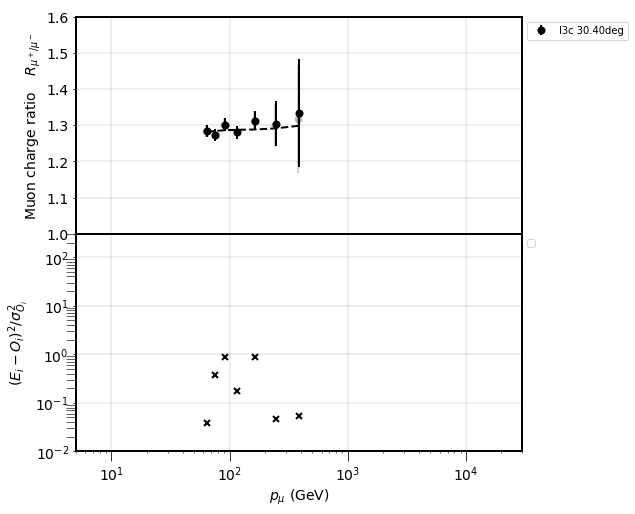

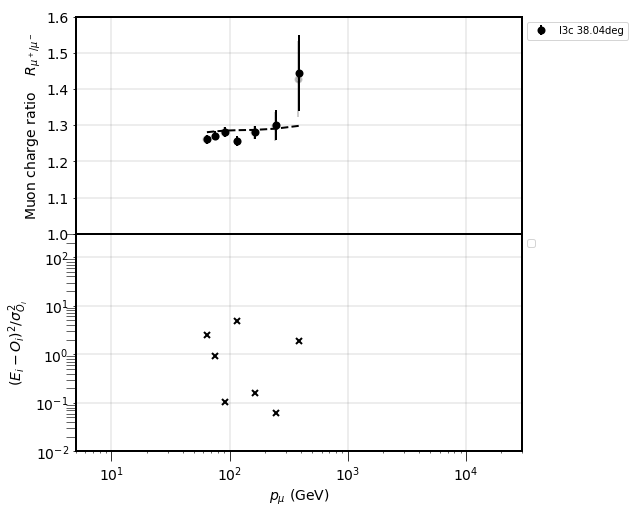

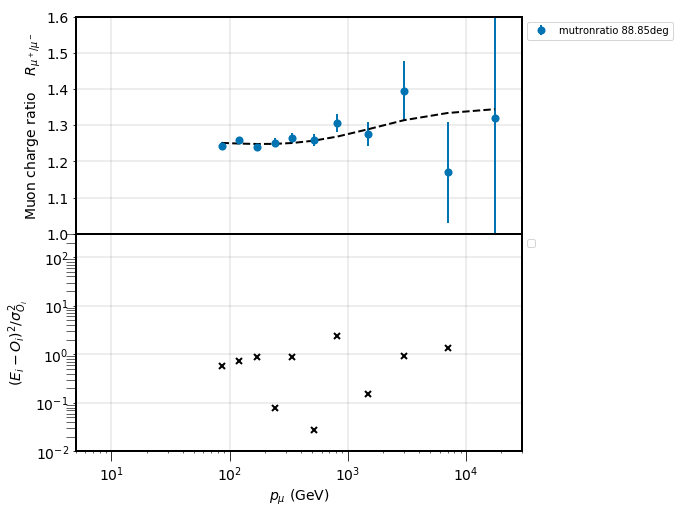

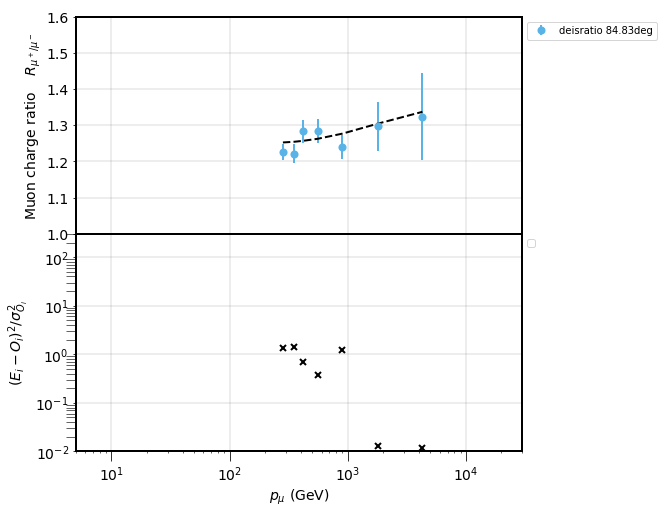

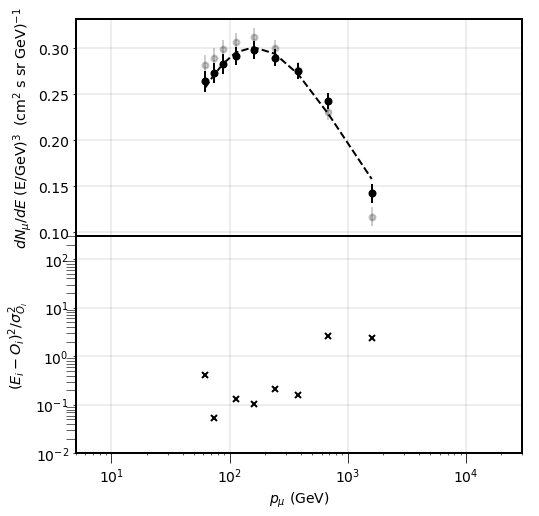

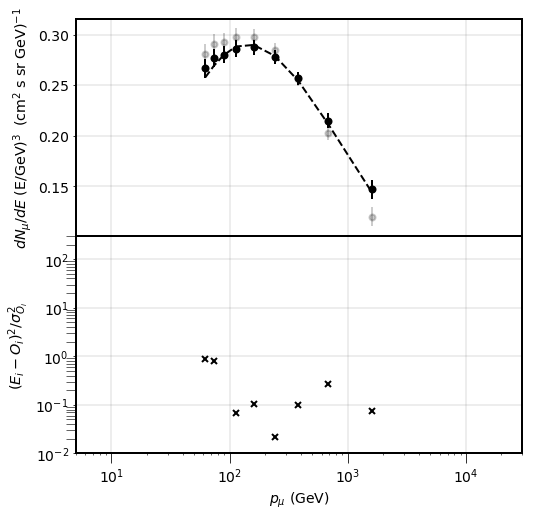

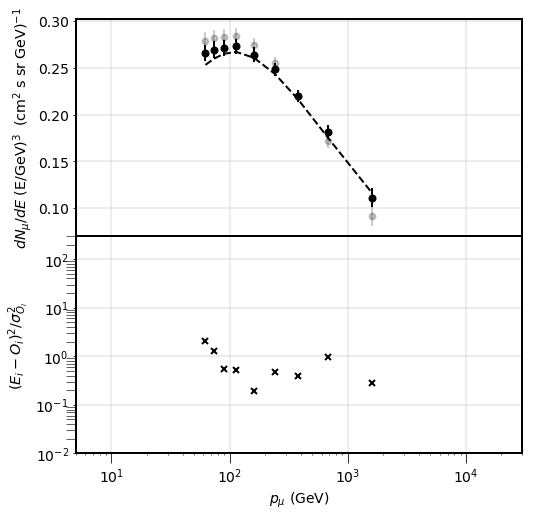

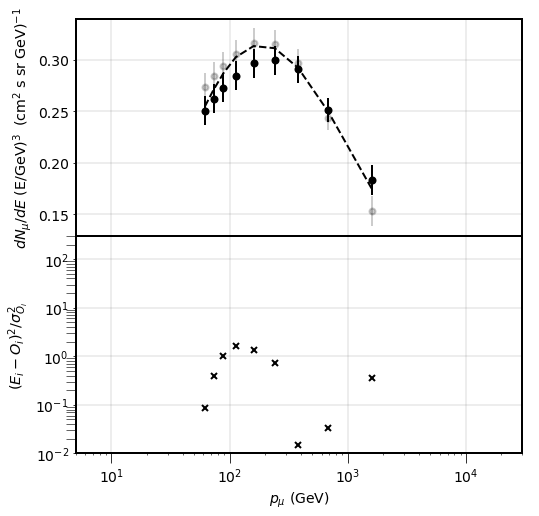

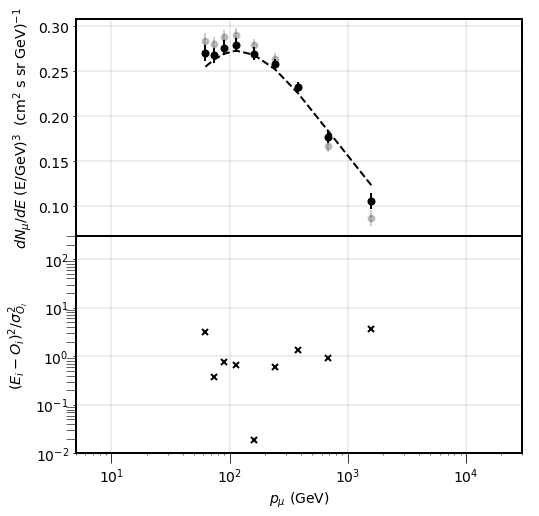

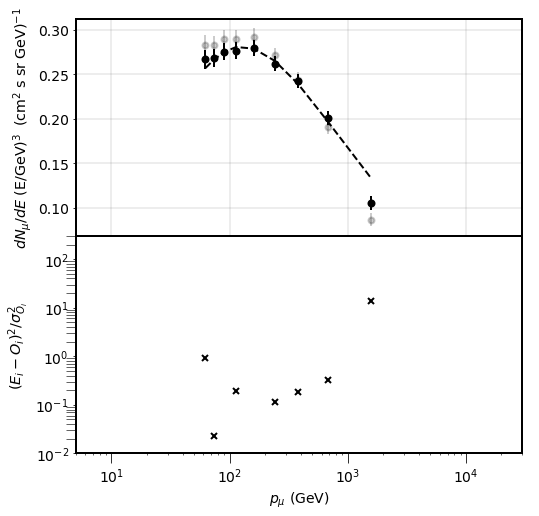

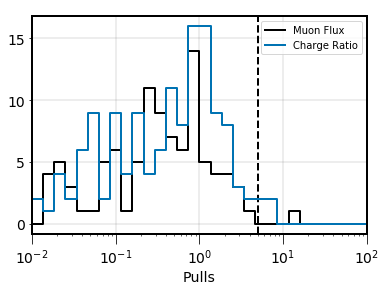

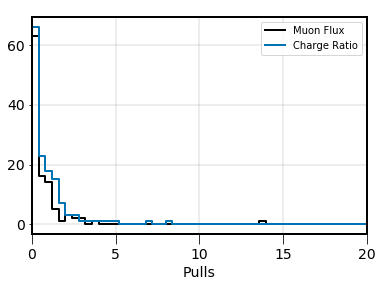

In [24]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
mfp.plot_comparison(fit, pullflag=10.,
                   emin=5)

In [25]:
reload(mfp)

MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

 Figure with the following coszen angles [0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 1
l3c 44.5613 0.7777414039689492 2
l3c 23.2197 0.4052602163253273 5
l3c 55.7711 0.9733893224590094 0
l3c 30.4015 0.5306062725450561 4
l3c 9.0687 0.15827867387560976 7
l3c 16.9617 0.29603751173552223 6
l3c 38.0475 0.6640541471525425 3
bessfull 8.1096 0.14153922101973215 7
bessfull 18.1949 0.31756091207111625 6
Saving figures


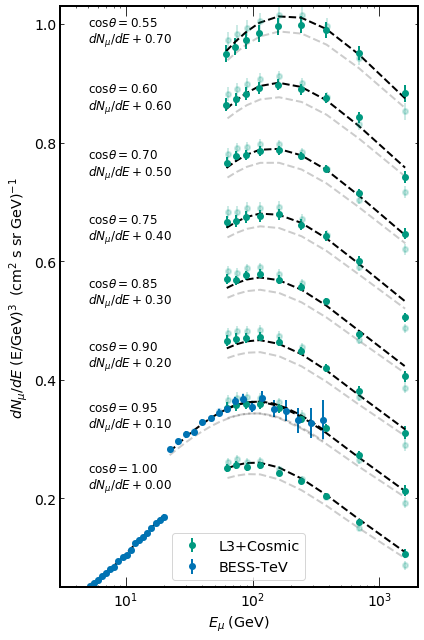

In [26]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
f1 = mfp.plotICRC21(fit, data_prefit = True)
if savefig:
    print('Saving figures')
    f1.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_vert_'+fitname+'.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.   0.05 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 3
l3c 44.5613 0.7777414039689492 4
l3c 23.2197 0.4052602163253273 7
l3c 55.7711 0.9733893224590094 2
l3c 30.4015 0.5306062725450561 6
l3c 9.0687 0.15827867387560976 9
l3c 16.9617 0.29603751173552223 8
l3c 38.0475 0.6640541471525425 5
mutronratio 88.8540 1.5507948535670415 0
opera 0.0000 0.0 9
deisratio 84.8364 1.4806745055389174 1
cms 0.0000 0.0 9
bessfull 8.1096 0.14153922101973215 9
bessfull 18.1949 0.31756091207111625 8
minos 0.0000 0.0 9
Saving figures


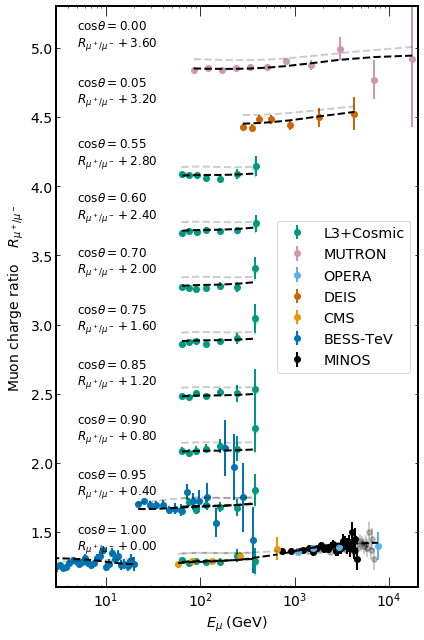

In [27]:
reload(mfp)
f2 = mfp.plotICRC21(fit, data= 'ratio',data_prefit = True)
if savefig:
    print('Saving figures')
    f2.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/ratio_vert_'+fitname+'.pdf')

MufitPlots does not use the mceq flux evaluator directly


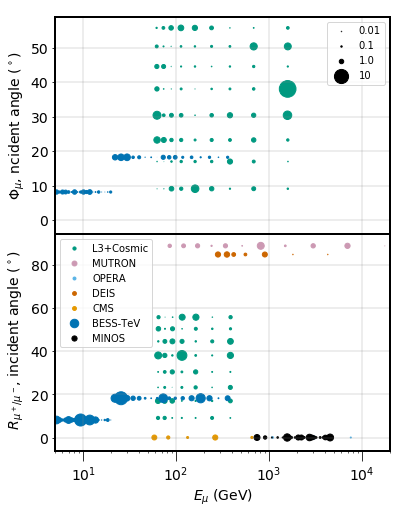

In [28]:
reload(mfp)
f1 = mfp.plotPulls(mufit=fit, pull_scale=20, log_pulls=False
                  )

In [29]:
minos_errors = one_m.minos()
pickle.dump(fit.results, open(filename, 'wb'))
print('Written', filename)

('Written', '/home/jp/projects/atm_nu/ddm_results/daemon_prd_nd.pkl')
